In [41]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Paths for preprocessed data
PREPROCESSED_TRAIN_DIR = "../data/preprocessed_data/traffic/trainNew/"
PREPROCESSED_TEST_DIR = "../data/preprocessed_data/traffic/testNew"

# Parameters
image_size = (100, 100)

# Load preprocessed training data
print("Loading preprocessed training data...")
X_train = []
Y_train = []

for class_name in os.listdir(PREPROCESSED_TRAIN_DIR):
    class_dir = os.path.join(PREPROCESSED_TRAIN_DIR, class_name)
    label = int(class_name)  # Assuming directories are named by class numbers
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Images are already grayscale
        if img is not None:
            X_train.append(img)
            Y_train.append(label)

X_train = np.array(X_train).reshape(-1, *image_size, 1)
Y_train = np.array(Y_train)
print(f"Loaded {X_train.shape[0]} training images.")

Loading preprocessed training data...
Loaded 4170 training images.


In [4]:
# load preprocessed test data
print("Loading preprocessed test data...")
X_test = []

for img_name in os.listdir(PREPROCESSED_TEST_DIR):
    img_path = os.path.join(PREPROCESSED_TEST_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Images are already grayscale
    if img is not None:
        X_test.append(img)

X_test = np.array(X_test).reshape(-1, *image_size, 1)
print(f"Loaded {X_test.shape[0]} test images.")

Loading preprocessed test data...
Loaded 1994 test images.


In [7]:
# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize the data (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

Flattening the images...
Standardizing the data...


In [47]:
# Apply PCA
print("Applying PCA...")
n_components = 2  
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original shape: {X_train_flattened.shape}")
print(f"PCA-reduced shape: {X_train_pca.shape}")

Applying PCA...
Original shape: (4170, 10000)
PCA-reduced shape: (4170, 2)


Applying Elbow Method...


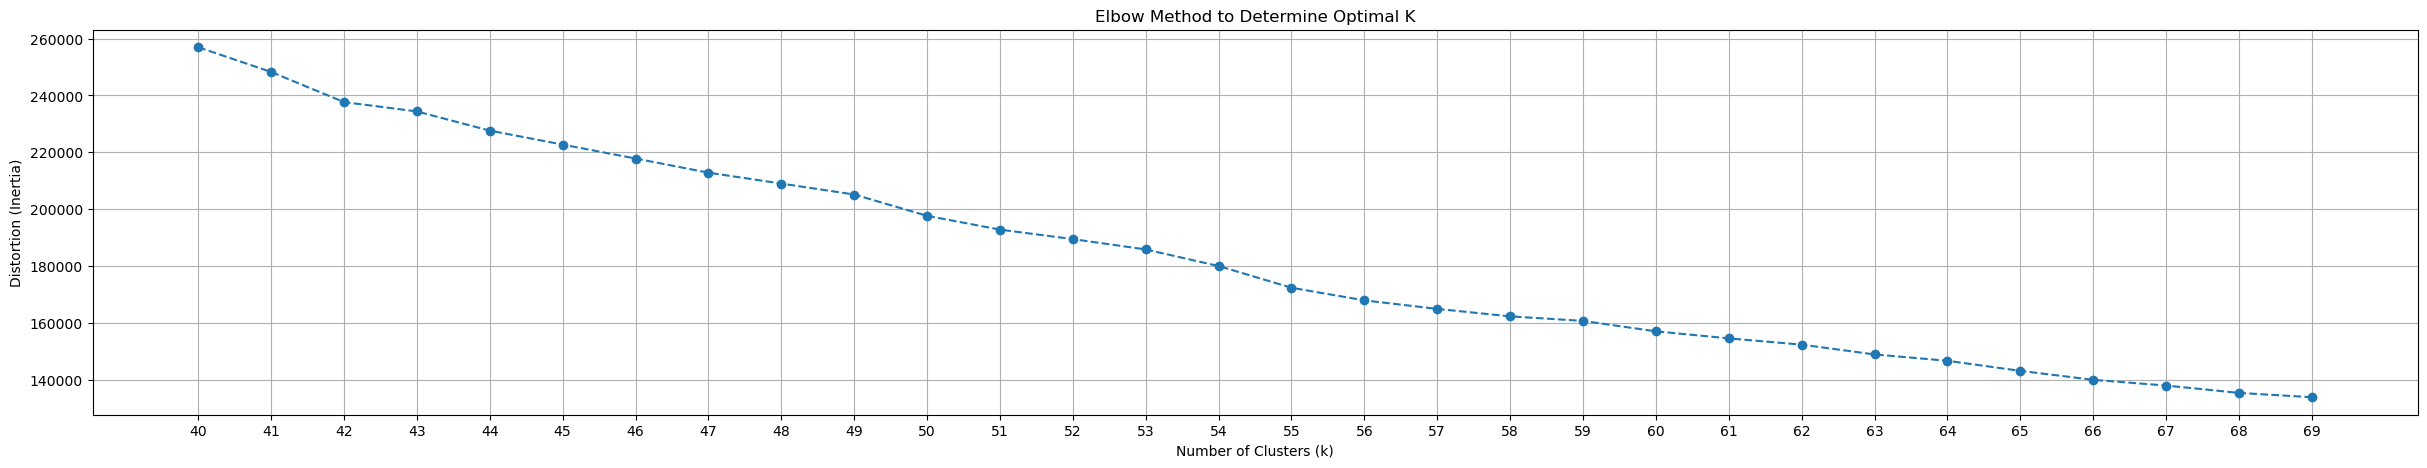

In [51]:
# Elbow Method: Determine optimal number of clusters
print("Applying Elbow Method...")
distortions = []
K = range(40, 70)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    distortions.append(kmeans.inertia_)  # Inertia measures within-cluster sum of squares

# Plot the elbow curve
plt.figure(figsize=(30, 5))
plt.plot(K, distortions, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.xticks(K)
plt.grid()
plt.show()

We used the range of 40-70 to test the 'k' values as our dataset has a large number of classes. 

Optimal number of clusters based on the elbow method: 42


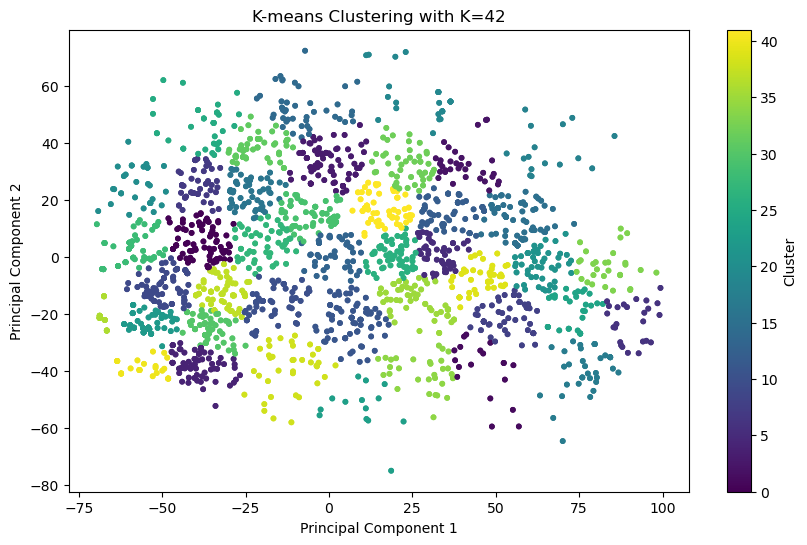

In [58]:
# Choose optimal k based on the elbow point
optimal_k = 42 
print(f"Optimal number of clusters based on the elbow method: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_pca)

# Cluster assignments
train_clusters = kmeans.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', s=10)
plt.title(f'K-means Clustering with K={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [59]:
kmeans_analysis = pd.DataFrame({
    'original_label': Y_train,  # True labels
    'cluster_label': train_clusters  # Cluster assignments
})

# Map cluster labels to original labels (majority voting)
cluster_mapping = kmeans_analysis.groupby('cluster_label')['original_label'].agg(lambda x: x.value_counts().index[0])
mapped_labels = train_clusters.copy()
for cluster_id, label in cluster_mapping.items():
    mapped_labels[train_clusters == cluster_id] = label

# Metrics for multiclass
true_labels = Y_train  # Original true labels
predicted_labels = mapped_labels  # Mapped labels

# Calculate metrics with `zero_division=0` to suppress warnings for undefined cases
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1 Score (Weighted):", f1)

Accuracy: 0.23645083932853717
Precision (Weighted): 0.15694429742536353
Recall (Weighted): 0.23645083932853717
F1 Score (Weighted): 0.17721760838459902


Optimal number of clusters based on the elbow method: 55


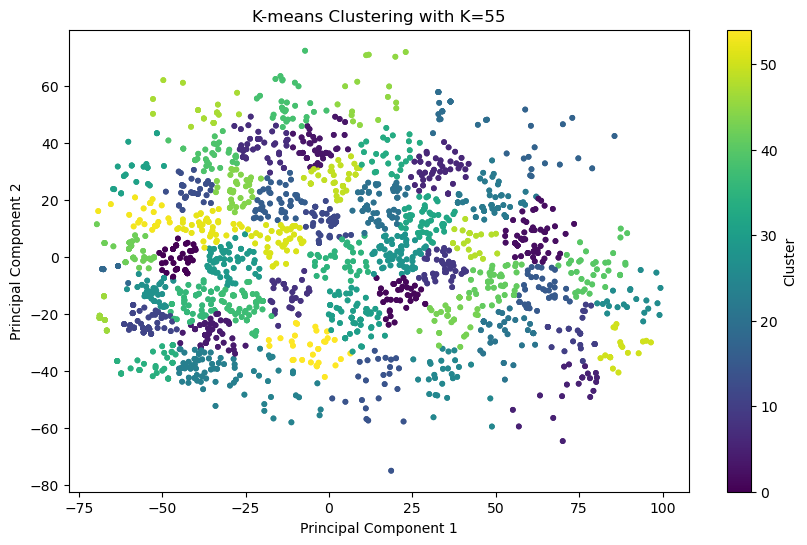

In [60]:
# Choose optimal k based on the elbow point
optimal_k = 55
print(f"Optimal number of clusters based on the elbow method: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_pca)

# Cluster assignments
train_clusters = kmeans.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', s=10)
plt.title(f'K-means Clustering with K={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [61]:
# Create a DataFrame to analyze clusters
kmeans_analysis = pd.DataFrame({
    'original_label': Y_train,  # True labels
    'cluster_label': train_clusters  # Cluster assignments
})

# Map cluster labels to original labels (majority voting)
cluster_mapping = kmeans_analysis.groupby('cluster_label')['original_label'].agg(lambda x: x.value_counts().index[0])
mapped_labels = train_clusters.copy()
for cluster_id, label in cluster_mapping.items():
    mapped_labels[train_clusters == cluster_id] = label

# Metrics for multiclass
true_labels = Y_train  # Original true labels
predicted_labels = mapped_labels  # Mapped labels

# Calculate metrics with `zero_division=0` to suppress warnings for undefined cases
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1 Score (Weighted):", f1)

Accuracy: 0.2589928057553957
Precision (Weighted): 0.18041189967030224
Recall (Weighted): 0.2589928057553957
F1 Score (Weighted): 0.19877975720580848


K-Means is not optimal for our dataset due to the low accuracy of 55 and 42 clusters shown above. However, 55 clusters has a better accuracy than 42 clusters.

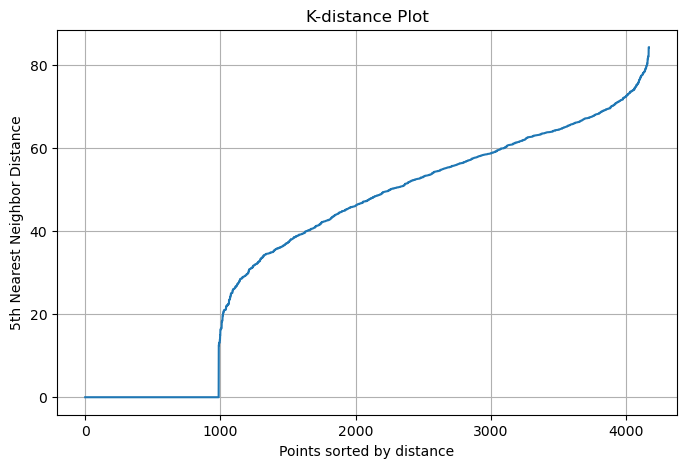

In [23]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_train_pca)
distances, indices = neighbors_fit.kneighbors(X_train_pca)

# Sort distances and plot
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid()
plt.show()

In [28]:
# DBSCAN
eps = 30  # Maximum distance between two points in the same cluster
min_samples = 5  # Minimum number of points to form a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train_pca)

Number of clusters: 127
Number of noise points: 2852


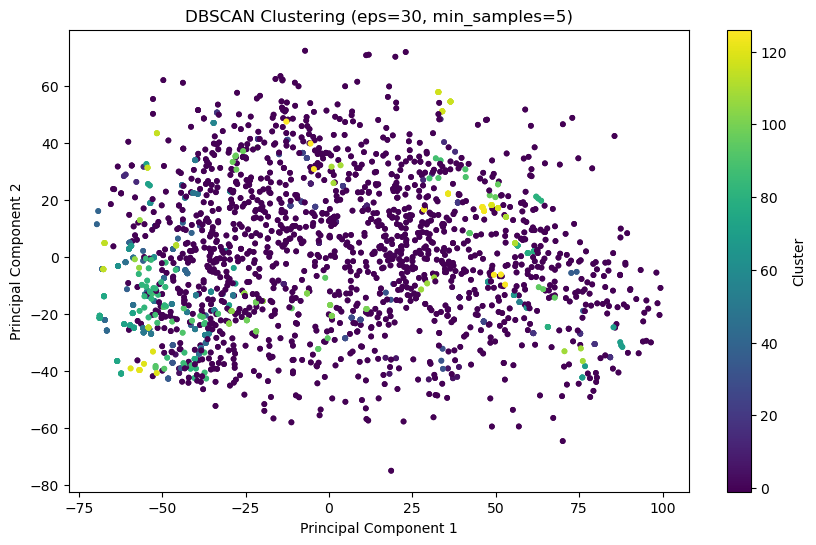

In [29]:
# Evaluate Results
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise_points = list(dbscan_labels).count(-1)
print(f"Number of clusters: {num_clusters}")
print(f"Number of noise points: {num_noise_points}")

# Visualize Clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [62]:
# Exclude noise points (-1) for evaluation
mask = dbscan_labels != -1  # Filter out noise points
filtered_labels = dbscan_labels[mask]
filtered_true_labels = Y_train[mask]

# Map cluster labels to original labels (majority voting)
dbscan_analysis = pd.DataFrame({
    'original_label': filtered_true_labels,
    'cluster_label': filtered_labels
})

# Map each cluster label to the most frequent original label in the cluster
cluster_mapping = dbscan_analysis.groupby('cluster_label')['original_label'].agg(lambda x: x.value_counts().index[0])
mapped_labels = filtered_labels.copy()
for cluster_id, label in cluster_mapping.items():
    mapped_labels[filtered_labels == cluster_id] = label

# Metrics for multiclass (excluding noise points)
true_labels = filtered_true_labels
predicted_labels = mapped_labels

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("Accuracy (excluding noise):", accuracy)
print("Precision (Weighted, excluding noise):", precision)
print("Recall (Weighted, excluding noise):", recall)
print("F1 Score (Weighted, excluding noise):", f1)

Accuracy (excluding noise): 0.9787556904400607
Precision (Weighted, excluding noise): 0.9880257577526166
Recall (Weighted, excluding noise): 0.9787556904400607
F1 Score (Weighted, excluding noise): 0.9793183397022043


DBSCAN outperforms K-means for this dataset as it groups points based on density, handles noise effectively and understands patterns. It is one of the best performing models for this dataset as many traffic signs often follow a similar pattern.